In [66]:
import datetime
import requests
import math
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [67]:
perf_dir = "../../data/perf"
base_url = "http://le-terror:9090/api/v1/query"

models = ["postgres", "e5", "labse", "gte"]
units = ["page", "paragraph", "sentence"]
steps = ["indexing", "search"][:1]

In [68]:
colors = [
    "#CC1F1A",
    "#1F9D55",
    "#2779BD",
    "#794ACF",
    "#EF5753",
    "#51D88A",
    "#6CB2EB",
    "#A779E9"
]

In [69]:
def get_time(timestamp_iso: str):
    return datetime.datetime.fromisoformat(
        timestamp_iso + "+00:00"
    ).timestamp()


def set_attr(obj: dict, path: str, value, *, append: bool = False):
    keys = path.split(".")
    last_key = keys[-1]

    for key in keys[:-1]:
        if key not in obj:
            obj[key] = {}

        obj = obj[key]

    if last_key in obj:
        if append:
            obj[last_key].append(value)
        else:
            obj[last_key] = value
    else:
        if append:
            obj[last_key] = [value]
        else:
            obj[last_key] = value


def get_attr(obj: dict, path: str):
    keys = path.split(".")
    last_key = keys[-1]

    for key in keys[:-1]:
        if key not in obj:
            return None

        obj = obj[key]

    if last_key not in obj:
        return None

    return obj[last_key]


def safe_list_get(l, idx, default):
    try:
        return l[idx]
    except IndexError:
        return default


def merge_sum(a, b):
    n = max(len(a), len(b))
    return [safe_list_get(a, i, 0) + safe_list_get(b, i, 0) for i in range(n)]


def sort_fn(item):
    id = item["metric"].get("id")
    name = item["metric"].get("name")
    return name if name else id

In [70]:
queries = [
    {
        "label": "CPU Time",
        "unit": "Seconds",
        "key": "cpu_time_seconds",
        "query_fn": lambda services, duration, end: f"delta(container_cpu_usage_seconds_total{{name=~\"{services}\"}}[{duration}s] @ {end})",
        "formatter_fn": lambda value: round(value, 0)
    },
    {
        "label": "Average Memory Usage",
        "unit": "Megabytes",
        "key": "mem_avg_mb",
        "query_fn": lambda services, duration, end: f"avg_over_time(container_memory_working_set_bytes{{name=~\"{services}\"}}[{duration}s] @ {end})",
        "formatter_fn": lambda value: round(value / 1024 / 1024, 0)
    },
    {
        "label": "Maximum Memory Usage",
        "unit": "Megabytes",
        "key": "mem_max_mb",
        "query_fn": lambda services, duration, end: f"max_over_time(container_memory_working_set_bytes{{name=~\"{services}\"}}[{duration}s] @ {end})",
        "formatter_fn": lambda value: round(value / 1024 / 1024, 0)
    },
    {
        "label": "GPU Average Usage",
        "unit": "Percent",
        "key": "gpu_usage_percent",
        "query_fn": lambda _, duration, end: f"avg_over_time(nvidia_smi_utilization_gpu_ratio[{duration}s] @ {end})",
        "formatter_fn": lambda value: round(value * 100, 0)
    },
    {
        "label": "GPU Time",
        "unit": "Seconds",
        "key": "gpu_time_seconds",
        "query_fn": lambda _, duration, end: f"avg_over_time(nvidia_smi_utilization_gpu_ratio[{duration}s] @ {end}) * {duration}",
        "formatter_fn": lambda value: round(value, 0)
    },
    {
        "label": "GPU Maximum Memory Usage",
        "unit": "Megabytes",
        "key": "gpu_mem_max_bytes",
        "query_fn": lambda _, duration, end: f"max_over_time(nvidia_smi_memory_used_bytes[{duration}s] @ {end})",
        "formatter_fn": lambda value: round(value / 1024 / 1024, 0)
    },
    {
        "label": "GPU Average Power Draw",
        "unit": "Watts",
        "key": "gpu_draw_avg_watts",
        "query_fn": lambda _, duration, end: f"avg_over_time(nvidia_smi_power_draw_watts[{duration}s] @ {end})",
        "formatter_fn": lambda value: round(value, 2)
    },
    {
        "label": "GPU Total Power Draw",
        "unit": "Kilowatt Hours",
        "key": "gpu_draw_kwh",
        "query_fn": lambda _, duration, end: f"avg_over_time(nvidia_smi_power_draw_watts[{duration}s] @ {end}) * {duration} / 60 / 60 / 1000",
        "formatter_fn": lambda value: round(value, 3)
    },
    {
        "label": "Disk Capacity Used",
        "unit": "Megabytes",
        "key": "disk_capacity_used_mb",
        "query_fn": lambda _, duration, end: f"delta(container_fs_usage_bytes{{id=\"/\", device=\"/dev/nvme0n1p1\"}}[{duration}s] @ {end})",
        "formatter_fn": lambda value: round(value / 1024 / 1024, 0)
    },
    {
        "label": "Duration",
        "unit": "Minutes",
        "key": "duration_minutes",
        "query_fn": lambda _, duration, end: f"count_over_time(cadvisor_version_info[{duration}s] @ {end}) / 60",
        "formatter_fn": lambda value: round(value, 2)
    }
]

chunks = [
    {
        "labels": ["indexing", "sentence", "postgres"],
        "services": ["script", "postgres"],
        "range": (
            "2025-03-07T08:08:19.561463",
            "2025-03-07T08:27:02.770915"
        )
    },
    {
        "labels": ["indexing", "paragraph", "postgres"],
        "services": ["script", "postgres"],
        "range": (
            "2025-03-07T08:02:32.443637",
            "2025-03-07T08:07:28.522516"
        )
    },
    {
        "labels": ["indexing", "page", "postgres"],
        "services": ["script", "postgres"],
        "range": (
            "2025-03-07T07:59:16.506918",
            "2025-03-07T08:01:33.740916"
        )
    },

    {
        "labels": ["indexing", "sentence", "e5"],
        "services": ["script", "meilisearch"],
        "range": (
            "2025-03-07T20:32:08.138014",
            "2025-03-08T00:39:07.533982"
        )
    },
    {
        "labels": ["indexing", "paragraph", "e5"],
        "services": ["script", "meilisearch"],
        "range": (
            "2025-03-07T08:33:22.888788",
            "2025-03-07T10:49:45.236555"
        )
    },
    {
        "labels": ["indexing", "page", "e5"],
        "services": ["script", "meilisearch"],
        "range": (
            "2025-03-07T14:20:33.326632",
            "2025-03-07T15:34:24.551400"
        )
    },

    {
        "labels": ["indexing", "sentence", "labse"],
        "services": ["script", "meilisearch"],
        "range": (
            "2025-03-08T06:36:19.337161",
            "2025-03-08T08:46:58.672995"
        )
    },
    {
        "labels": ["indexing", "paragraph", "labse"],
        "services": ["script", "meilisearch"],
        "range": (
            "2025-03-07T11:38:27.295439",
            "2025-03-07T12:33:18.145717"
        )
    },
    {
        "labels": ["indexing", "page", "labse"],
        "services": ["script", "meilisearch"],
        "range": (
            "2025-03-07T17:46:23.207389",
            "2025-03-07T18:00:54.466813"
        )
    },

    {
        "labels": ["indexing", "sentence", "gte"],
        "services": ["script", "meilisearch"],
        "range": (
            "2025-03-08T10:27:43.220045",
            "2025-03-08T13:00:51.794683"
        )
    },
    {
        "labels": ["indexing", "paragraph", "gte"],
        "services": ["script", "meilisearch"],
        "range": (
            "2025-03-07T12:39:11.749573",
            "2025-03-07T14:12:18.570604"
        )
    },
    {
        "labels": ["indexing", "page", "gte"],
        "services": ["script", "meilisearch"],
        "range": (
            "2025-03-07T18:40:07.720204",
            "2025-03-07T19:48:25.002033"
        )
    },
]

In [71]:
results = {}

for query in queries:
    query_key, query_constructor, value_formatter = (
        query["key"],
        query["query_fn"],
        query["formatter_fn"]
    )

    for chunk in chunks:
        chunk_labels, chunk_services, chunk_range = (
            chunk["labels"],
            chunk["services"],
            chunk["range"]
        )

        start, end = (
            get_time(chunk_range[0]),
            get_time(chunk_range[1])
        )

        services = "|".join(chunk_services)
        duration = math.ceil(end - start)

        response = requests.get(base_url, params={
            "query": query_constructor(
                services,
                duration,
                end
            )
        })

        data = response.json()
        result = data["data"]["result"]
        result.sort(key=sort_fn)

        sample = []
        sample_services = []
        for item in result:
            sample.append(float(item["value"][1]))

            name = item["metric"].get("name")
            if name:
                sample_services.append(name)

        base_path = ".".join(chunk_labels)
        set_attr(results, f"{base_path}.{query_key}", sample, append=False)

        if len(sample_services) > 0:
            set_attr(
                results,
                f"{base_path}.services.{query_key}",
                sample_services,
                append=True
            )

In [72]:
timestamp = datetime.datetime.now().isoformat()
with open(f"{perf_dir}/{timestamp}.json", "w") as file:
    json.dump(results, file, indent=2)

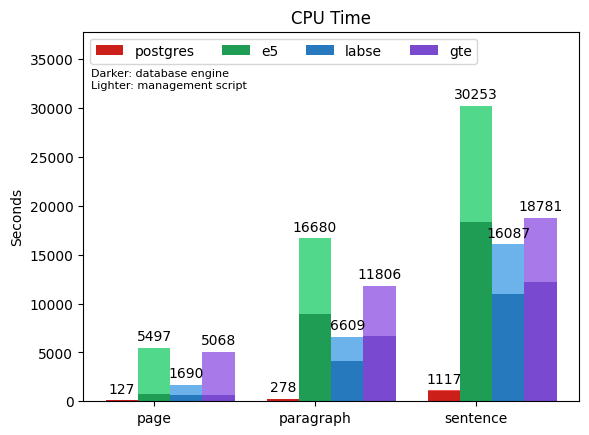

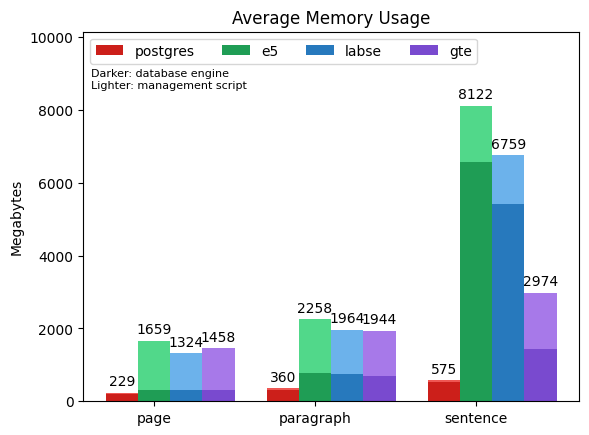

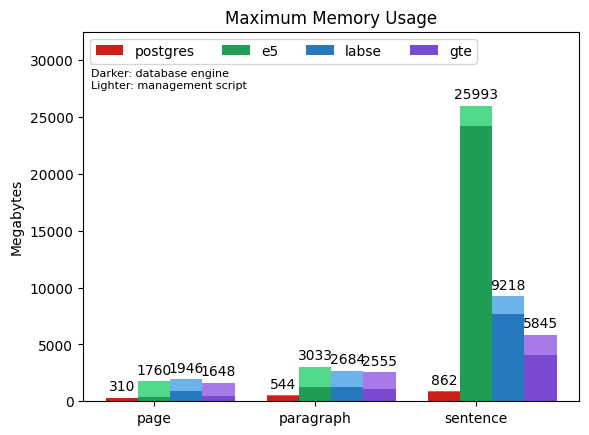

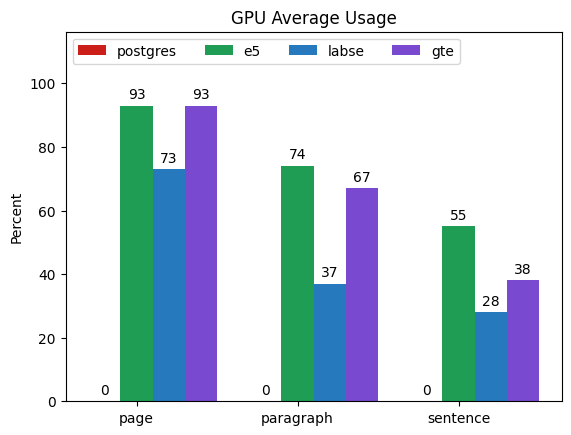

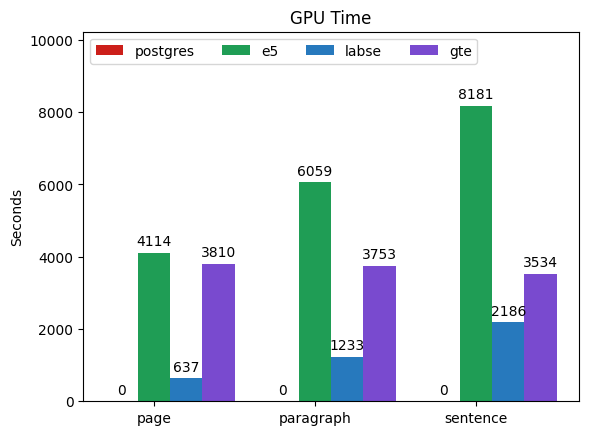

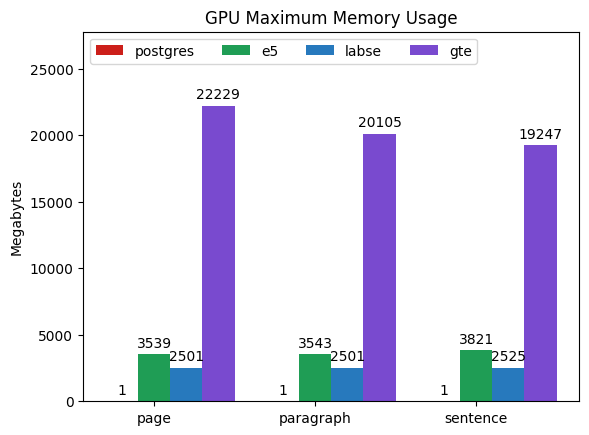

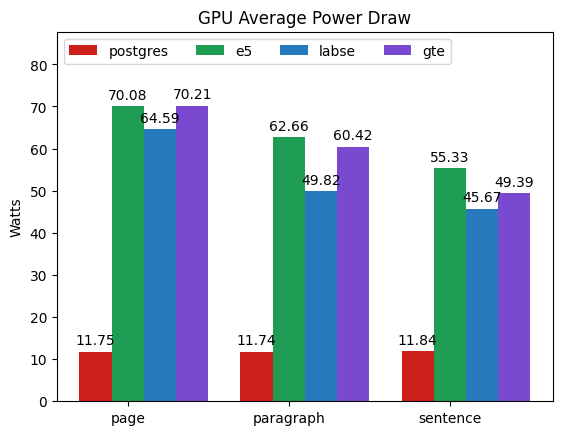

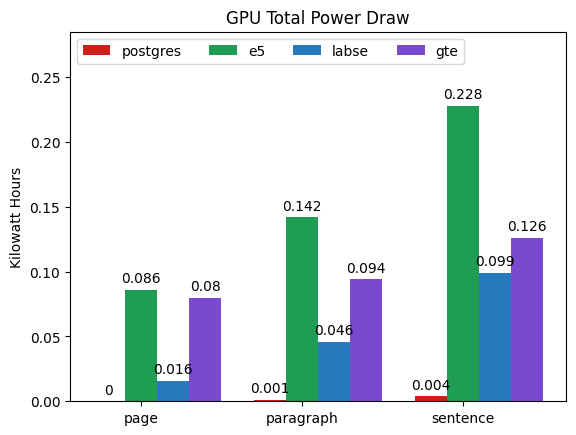

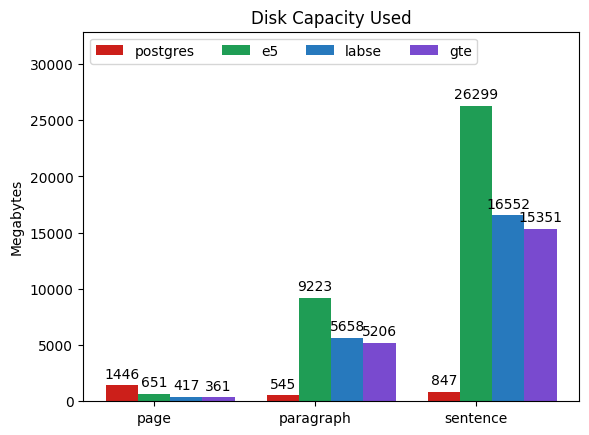

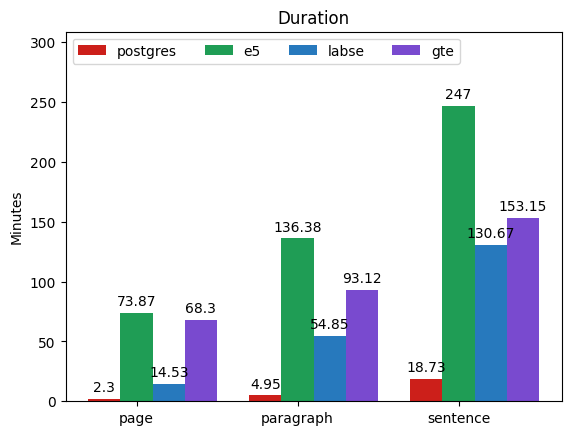

In [73]:
for idx, query in enumerate(queries):
    query_label, query_key, value_formatter = (
        query["label"],
        query["key"],
        query["formatter_fn"]
    )

    data = {}

    for unit in units:
        for model in models:
            sample = get_attr(
                results,
                f"indexing.{unit}.{model}.{query_key}"
            )

            if sample is None:
                set_attr(data, model, [], append=True)
            else:
                formatted_sample = list(map(value_formatter, sample))
                set_attr(data, model, formatted_sample, append=True)

    x = np.arange(len(units))
    width = 0.2
    multiplier = 0
    max_y = 0

    fig, ax = plt.subplots()
    legend_rects = []
    max_y = 0

    is_multidimensional = False

    for model, samples in data.items():
        offset = width * multiplier
        dimensions = max(map(len, samples))

        if dimensions > 1:
            is_multidimensional = True

        y_prev = None
        y_max = []
        for i in range(dimensions):
            y = list(map(lambda sample: safe_list_get(sample, i, 0), samples))
            color_idx = models.index(model) + i * len(models)

            rects = ax.bar(
                x + offset,
                y,
                width, y_prev,
                label=model,
                color=colors[color_idx]
            )

            if i == 0:
                legend_rects.append(rects)

            if i == dimensions - 1:
                ax.bar_label(rects, padding=3)

            y_prev = y
            y_max = merge_sum(y_max, y)

        multiplier += 1
        max_y = max(max_y, max(y_max))

    ax.set_title(query["label"])

    if is_multidimensional:
        ax.text(
            0.015, 0.90,
            "Darker: database engine\nLighter: management script",
            fontsize=8,
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes
        )

    ax.set_ylabel(query["unit"])
    ax.set_ybound(0, max_y * 1.25)
    ax.set_xticks(x + width, units)
    ax.legend(legend_rects, models, loc='upper left', ncols=4)

    plt.show()